In [96]:
import random
import os
import sys
import time
import numpy as np
import math
import zlib
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

In [97]:
from CurveCGen import *
from CurveEA import *

In [98]:
import subprocess
BLENDER_PATH="C:\\Program Files\\Blender Foundation\\Blender 3.3\\blender.exe"

In [99]:
OUTPUT_PATH="E:\\Research\\Statue Generator\\Generations"

In [100]:
def shannon_entropy(file_path):
    with open(file_path, "rb") as f:
        bytes = f.read()
    prob = [float(bytes.count(b)) / len(bytes) for b in set(bytes)]
    entropy = -sum([p * math.log(p) / math.log(2.0) for p in prob])
    return round(entropy,6)

In [101]:
def golden_ratio(vertices, edges):
    def euclidean_distance(v1, v2):
        return ((v2[0] - v1[0])**2 + (v2[1] - v1[1])**2 + (v2[2] - v1[2])**2)**0.5
        
    golden_ratio = 1.61803398874989484820
    ratio_sum = 0
    ratio_count = 0
    
    for edge in edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        length = euclidean_distance(v1, v2)
        ratio = length / golden_ratio
        if ratio >= 1:
            ratio = 1 / ratio
        ratio_sum += ratio
        ratio_count += 1
    
    return ratio_sum / ratio_count


In [102]:
def perimeter(vertices, edges):
    perimeter = 0
    for edge in edges:
        vertex1, vertex2 = edge
        x1, y1, z1 = vertices[vertex1]
        x2, y2, z2 = vertices[vertex2]
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        perimeter += distance
    return perimeter

In [104]:
def compression_ratio(filepath):
    with open(filepath, mode="rb") as fin, open(filepath[:-6]+"_compressed", mode="wb") as fout:
            data = fin.read()
            compressed_data = zlib.compress(data, zlib.Z_BEST_COMPRESSION)
            orig=sys.getsizeof(data)
            comp=sys.getsizeof(compressed_data)
            ratio=comp/orig
    
            return ratio

In [105]:
def gen_blender(ARR,GEN_NUM):
    
    os.mkdir(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))
    
    for i,C in enumerate(ARR):
        
        #[r,g,b,a,bd,me,ro,ss,[VERTICES,EDGES],[new_L,new_B,new_H]]

        VERTS=C[8][0]
        EDGES=C[8][1]
        MATERIAL=str([C[0],C[1],C[2],C[3]])
        BD=str(C[4])
        ME=str(C[5])
        RO=str(C[6])
        SS=str(C[7])
        FILE_NUM=str(i)
        
        with open(f'{OUTPUT_PATH}\\GEN_{GEN_NUM}\\VERTS_G{GEN_NUM}_S{i}.txt', 'w') as f:
            f.writelines(str(VERTS))

        #subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G{GEN_NUM}_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))],capture_output=True,shell=True)
        #time.sleep(60)
        
        #print(f'Statue {i} Saved!')

## Basic Parameters for generation

In [106]:
L,B,H=10,12,17
POPULATION_SIZE=100

In [107]:
PARAMS=[]

## Initial Population

In [108]:
%%time

INITIAL_POPULATION=[]

volume=L*B*H
bin_size=int(volume/POPULATION_SIZE)

bins=[b for b in range(4,int(volume),bin_size)]
print(bins)

n_verts=[]

for i in range(len(bins)-1):
    n=random.randint(bins[i],bins[i+1])
    n_verts.append(n)

random.shuffle(n_verts)
print("\n",n_verts,"\n")
    
for i in range(POPULATION_SIZE):
    CH=generate_chromosome(L,B,H,n_verts[i])
    INITIAL_POPULATION.append(CH)
    get_stats(CH)
    print(f"Params of Statue - {i} has been saved!")
    print('-'*125)

PARAMS.append(INITIAL_POPULATION)

[4, 24, 44, 64, 84, 104, 124, 144, 164, 184, 204, 224, 244, 264, 284, 304, 324, 344, 364, 384, 404, 424, 444, 464, 484, 504, 524, 544, 564, 584, 604, 624, 644, 664, 684, 704, 724, 744, 764, 784, 804, 824, 844, 864, 884, 904, 924, 944, 964, 984, 1004, 1024, 1044, 1064, 1084, 1104, 1124, 1144, 1164, 1184, 1204, 1224, 1244, 1264, 1284, 1304, 1324, 1344, 1364, 1384, 1404, 1424, 1444, 1464, 1484, 1504, 1524, 1544, 1564, 1584, 1604, 1624, 1644, 1664, 1684, 1704, 1724, 1744, 1764, 1784, 1804, 1824, 1844, 1864, 1884, 1904, 1924, 1944, 1964, 1984, 2004, 2024]

 [1491, 830, 11, 1734, 428, 1518, 1152, 1925, 124, 1923, 295, 1630, 26, 1110, 474, 454, 495, 1862, 809, 77, 887, 1330, 1068, 99, 779, 545, 1169, 1764, 1274, 1450, 1617, 1767, 1598, 1226, 166, 718, 1658, 863, 311, 1407, 1382, 570, 526, 1391, 1223, 373, 884, 1807, 337, 1577, 1289, 640, 1359, 1793, 1018, 242, 763, 1679, 650, 1465, 930, 1538, 1979, 205, 1252, 1715, 679, 115, 601, 1085, 1998, 2023, 349, 201, 419, 1872, 950, 997, 725, 1304, 189

(R, G, B, A) = (0.386677, 0.41566, 0.356884, 0.676096)
Number of vertices = 779
Number of edges = 778
Bevel Depth = 0.86
Metallic = 0.779438
Roughness = 0.425529
Subsurface Level = 0
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 24 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.712843, 0.127626, 0.182638, 0.674311)
Number of vertices = 545
Number of edges = 544
Bevel Depth = 0.37
Metallic = 0.566167
Roughness = 0.218492
Subsurface Level = 1
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 25 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.703063, 0.219146, 0.159413, 0.618153)
Number of vertices = 1169
Number of edges = 1168
Bevel Depth = 3.23
Metallic = 0.583089
Roughness = 0.298713
Subsurface Level = 3
New Bounding Box - (L,B,H) = (10,12,17)

(R, G, B, A) = (0.251493, 0.936805, 0.754825, 0.940302)
Number of vertices = 1807
Number of edges = 1806
Bevel Depth = 3.02
Metallic = 0.909072
Roughness = 0.28978
Subsurface Level = 1
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 47 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.976503, 0.447913, 0.973997, 0.432228)
Number of vertices = 337
Number of edges = 336
Bevel Depth = 0.39
Metallic = 0.381496
Roughness = 0.096658
Subsurface Level = 0
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 48 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.405143, 0.426633, 0.475103, 0.786124)
Number of vertices = 1577
Number of edges = 1576
Bevel Depth = 1.48
Metallic = 0.008156
Roughness = 0.151912
Subsurface Level = 4
New Bounding Box - (L,B,H) = (10,12,1

(R, G, B, A) = (0.864506, 0.824767, 0.145441, 0.253866)
Number of vertices = 1998
Number of edges = 1997
Bevel Depth = 0.34
Metallic = 0.173685
Roughness = 0.223608
Subsurface Level = 5
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 70 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.888099, 0.04002, 0.019274, 0.601681)
Number of vertices = 2023
Number of edges = 2022
Bevel Depth = 2.48
Metallic = 0.0217
Roughness = 0.305138
Subsurface Level = 3
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 71 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.717937, 0.031745, 0.069289, 0.942802)
Number of vertices = 349
Number of edges = 348
Bevel Depth = 2.16
Metallic = 0.103596
Roughness = 0.16221
Subsurface Level = 0
New Bounding Box - (L,B,H) = (10,12,17)


(R, G, B, A) = (0.809149, 0.619594, 0.940555, 0.769906)
Number of vertices = 1825
Number of edges = 1824
Bevel Depth = 0.83
Metallic = 0.512534
Roughness = 0.258189
Subsurface Level = 6
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 94 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.507776, 0.241113, 0.931623, 0.632049)
Number of vertices = 1132
Number of edges = 1131
Bevel Depth = 0.43
Metallic = 0.407486
Roughness = 0.005385
Subsurface Level = 6
New Bounding Box - (L,B,H) = (10,12,17)
Params of Statue - 95 has been saved!
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.542374, 0.560581, 0.745272, 0.579252)
Number of vertices = 257
Number of edges = 256
Bevel Depth = 3.08
Metallic = 0.325442
Roughness = 0.293009
Subsurface Level = 3
New Bounding Box - (L,B,H) = (10,12,

In [109]:
%%time

os.mkdir(OUTPUT_PATH+"\\GEN_0")

for i,C in enumerate(PARAMS[0]):

    VERTS=C[8][0]
    EDGES=C[8][1]
    MATERIAL=str([C[0],C[1],C[2],C[3]])
    BD=str(C[4])
    ME=str(C[5])
    RO=str(C[6])
    SS=str(C[7])
    FILE_NUM=str(i)
    
    with open(f'{OUTPUT_PATH}\\GEN_0\\VERTS_G{0}_S{i}.txt', 'w') as f:
        f.writelines(str(VERTS))

    
    #subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G0_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_0")],capture_output=True,shell=True)

    #time.sleep(60)
    
    print(f'Statue {i} Saved!')
    

Statue 0 Saved!
Statue 1 Saved!
Statue 2 Saved!
Statue 3 Saved!
Statue 4 Saved!
Statue 5 Saved!
Statue 6 Saved!
Statue 7 Saved!
Statue 8 Saved!
Statue 9 Saved!
Statue 10 Saved!
Statue 11 Saved!
Statue 12 Saved!
Statue 13 Saved!
Statue 14 Saved!
Statue 15 Saved!
Statue 16 Saved!
Statue 17 Saved!
Statue 18 Saved!
Statue 19 Saved!
Statue 20 Saved!
Statue 21 Saved!
Statue 22 Saved!
Statue 23 Saved!
Statue 24 Saved!
Statue 25 Saved!
Statue 26 Saved!
Statue 27 Saved!
Statue 28 Saved!
Statue 29 Saved!
Statue 30 Saved!
Statue 31 Saved!
Statue 32 Saved!
Statue 33 Saved!
Statue 34 Saved!
Statue 35 Saved!
Statue 36 Saved!
Statue 37 Saved!
Statue 38 Saved!
Statue 39 Saved!
Statue 40 Saved!
Statue 41 Saved!
Statue 42 Saved!
Statue 43 Saved!
Statue 44 Saved!
Statue 45 Saved!
Statue 46 Saved!
Statue 47 Saved!
Statue 48 Saved!
Statue 49 Saved!
Statue 50 Saved!
Statue 51 Saved!
Statue 52 Saved!
Statue 53 Saved!
Statue 54 Saved!
Statue 55 Saved!
Statue 56 Saved!
Statue 57 Saved!
Statue 58 Saved!
Statue 

### Plotting Bins

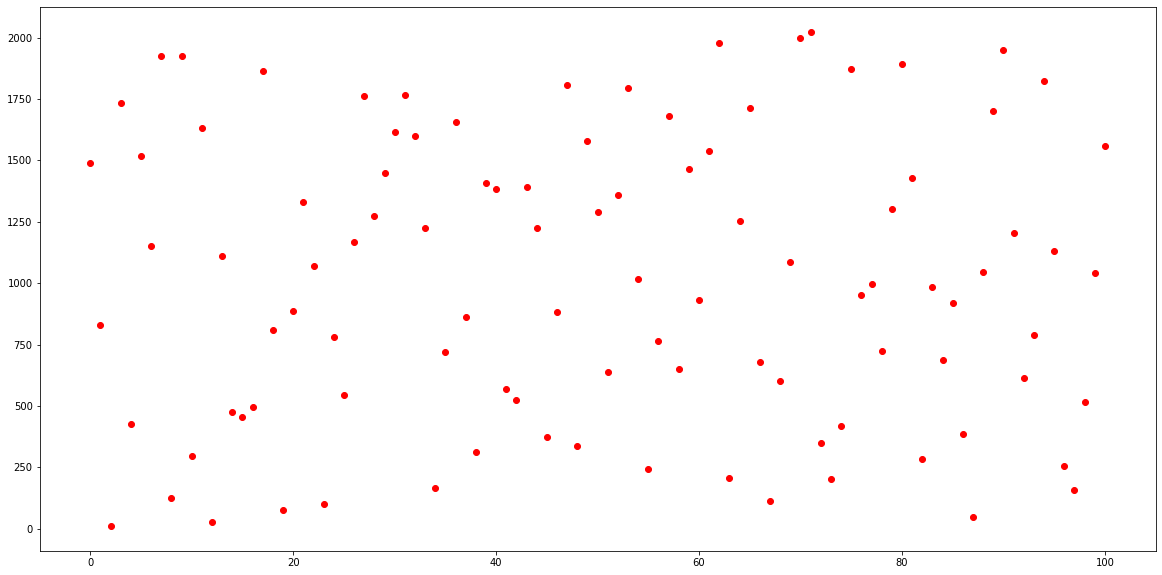

In [110]:
plt.figure(figsize=(20,10))
plt.plot(n_verts,'ro')

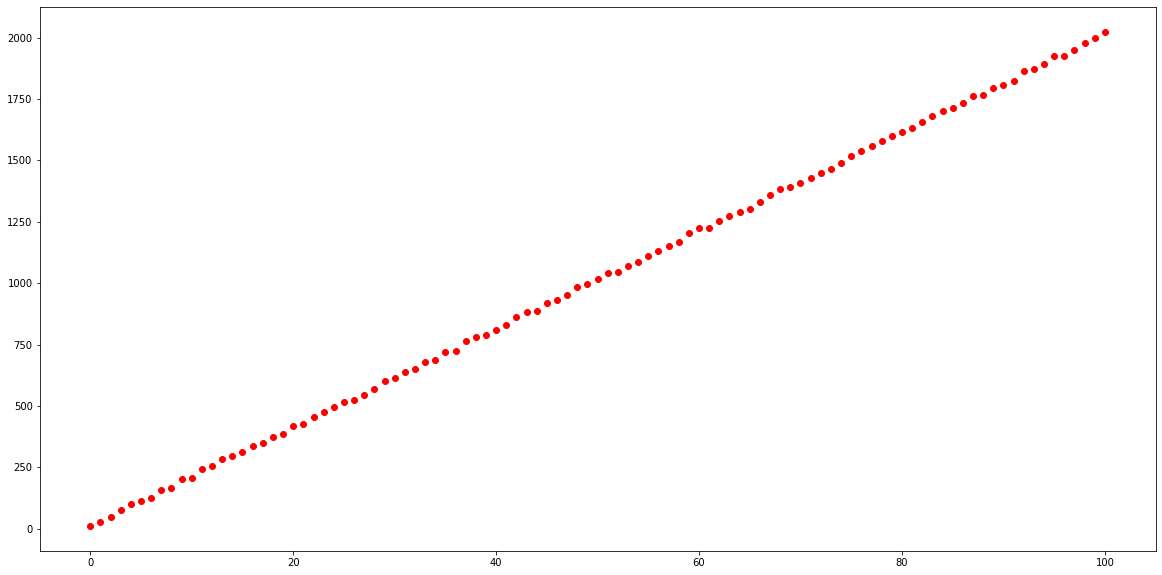

In [111]:
plt.figure(figsize=(20,10))
plt.plot(sorted(n_verts),'ro')

In [112]:
n_verts

[1491,
 830,
 11,
 1734,
 428,
 1518,
 1152,
 1925,
 124,
 1923,
 295,
 1630,
 26,
 1110,
 474,
 454,
 495,
 1862,
 809,
 77,
 887,
 1330,
 1068,
 99,
 779,
 545,
 1169,
 1764,
 1274,
 1450,
 1617,
 1767,
 1598,
 1226,
 166,
 718,
 1658,
 863,
 311,
 1407,
 1382,
 570,
 526,
 1391,
 1223,
 373,
 884,
 1807,
 337,
 1577,
 1289,
 640,
 1359,
 1793,
 1018,
 242,
 763,
 1679,
 650,
 1465,
 930,
 1538,
 1979,
 205,
 1252,
 1715,
 679,
 115,
 601,
 1085,
 1998,
 2023,
 349,
 201,
 419,
 1872,
 950,
 997,
 725,
 1304,
 1892,
 1427,
 283,
 983,
 686,
 918,
 387,
 46,
 1047,
 1699,
 1950,
 1204,
 612,
 791,
 1825,
 1132,
 257,
 159,
 518,
 1041,
 1558]

In [116]:
def volume(vertices):
    vertices=np.array(vertices)
    tri = Delaunay(vertices)
    tetrahedra = tri.simplices
    
    def tetrahedron_volume(a, b, c, d):
        return abs(np.dot((a - d), np.cross((b - d), (c - d)))) / 6

    tetra_volumes = [tetrahedron_volume(vertices[a], vertices[b], vertices[c], vertices[d]) for (a, b, c, d) in tetrahedra]

    total_volume = sum(tetra_volumes)
    
#     #print(tri.simplices)
#     tetra = vertices[tri.simplices]
#     volumes = np.zeros(len(tetra))

#     for i, t in enumerate(tetra):
#         a, b, c, d = t
#         v = (1.0/6.0) * np.abs(np.dot(b - a, np.cross(c - a, d - a)))
#         volumes[i] = v

#     total_volume = np.sum(volumes)
    
# #     ch=ConvexHull(vertices)
# #     total_volume=ch.volume
    
    return total_volume

## Crossover and Mutation for more generations

In [117]:
GENERATIONS=300

In [ ]:
%%time

ALL_FITNESS=[]
BEST_FITNESS=[]
MUTATION_CHOICES=[]
GEN_NUM=1

for _ in range(GENERATIONS):
    
    PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GEN_NUM-1)
    FITNESS=[]
    
    VOLUMES,PERIMETERS=[],[]
    
    for i in range(POPULATION_SIZE):
        
        VERTS=PARAMS[GEN_NUM-1][i][8][0]
        EDGES=PARAMS[GEN_NUM-1][i][8][1]
        
#         entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
#         entropy=entropy/8 
        
#         cr=compression_ratio(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
        
#         gr=golden_ratio(VERTS,EDGES)
        
        v=volume(VERTS)
        p=perimeter(VERTS,EDGES)
        
        VOLUMES.append(1/v)
        PERIMETERS.append(p)
#         print(f"Volume: {v}")
#         print(f"Perimeter: {p}")
    
        fitness=p/v
        FITNESS.append(round(fitness,6))
    
    
#     plt.figure()
#     plt.plot(PERIMETERS,VOLUMES,'ro')
#     plt.title(f"GEN-{GEN_NUM-1}")
#     plt.show()
    
    ALL_FITNESS.append(FITNESS)
    
    BEST_FITNESS.append(FITNESS.index(max(FITNESS)))
    print(f'Statue-{FITNESS.index(max(FITNESS))} has the best fitness value in {GEN_NUM-1} generation.')
    
    MODELS=[]
    
    GEN_MUTATION=[]
    
    for _ in range(int(POPULATION_SIZE/2)):
    
        #selecting 2 random parents from previous generation
        idx1,idx2=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p1=idx1 if FITNESS[idx1]>FITNESS[idx2] else idx2
        
        idx3,idx4=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p2=idx3 if FITNESS[idx3]>FITNESS[idx4] else idx4
        
        crossover_prob=round(random.random(),6)
        mutation_prob=round(random.random(),6)
        
        if mutation_prob<0.5:
            #mutate the children after crossover
            m1,choice1=mutate(PARAMS[GEN_NUM-1][p1],L,B,H)
            m2,choice2=mutate(PARAMS[GEN_NUM-1][p2],L,B,H)
            
            GEN_MUTATION.append(choice1)
            GEN_MUTATION.append(choice2)
            
        else:
            m1,m2=PARAMS[GEN_NUM-1][p1],PARAMS[GEN_NUM-1][p2]
        
        if crossover_prob<0.5:
            #perform crossover for the selected parents
            c1,c2=crossover(m1,m2)
        else:
            c1,c2=m1,m2
        
        
        MODELS.append(c1)
        MODELS.append(c2)
        
    #print(len(MODELS))
    #appending the mutated childs to PARAMS array
    PARAMS.append(MODELS)
    
    #appending mutation choices
    MUTATION_CHOICES.append(GEN_MUTATION)
    
    #generate blender file
    gen_blender(MODELS,GEN_NUM)
    
    print(f"Generation {GEN_NUM} generated successfully!")
    print("-"*120)
    
    GEN_NUM+=1

In [ ]:
ALL_FITNESS[0]

In [ ]:
plt.plot(ALL_FITNESS[0],'ro')

In [ ]:
FIT_FILE="E:\Research\Statue gen output\\Fitness_for_Map_1.txt"
with open(FIT_FILE, 'w') as f:
        f.writelines(str(ALL_FITNESS))

In [ ]:
len(MUTATION_CHOICES)

In [ ]:
%%time
PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GENERATIONS)
FINAL_FITNESS=[]

for i in range(POPULATION_SIZE):

#     entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
#     entropy=entropy/8

    VERTS=PARAMS[GEN_NUM-1][i][8][0]
    EDGES=PARAMS[GEN_NUM-1][i][8][1]
    v=volume(VERTS)
    p=perimeter(VERTS,EDGES)
#         print(f"Volume: {v}")
#         print(f"Perimeter: {p}")
    
    #fitness=volume+perimeter
    fitness=p/v
    FINAL_FITNESS.append(round(fitness,6))

In [ ]:
FINAL_FITNESS

In [ ]:
ALL_FITNESS.append(FINAL_FITNESS)

In [ ]:
BEST_FITNESS.append(FINAL_FITNESS.index(max(FINAL_FITNESS)))

## Plot fitness

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px

def plot_fitness(fitness):
    
    best_values=[]
    for g in fitness:
        best_values.append(max(g))
    
#     plt.figure(figsize=(20,10))
#     plt.plot(best_values)
#     plt.xlabel("Generation")
#     plt.ylabel("Fitness")
#     plt.show()

    fig = px.line(best_values, title='Best Fitness')
    fig.show()

In [ ]:
plot_fitness(ALL_FITNESS)

## Saving the parameters

In [ ]:
OP_FILE_NAME='E:\Research\Statue gen output\\NewEA_7_withDelaunayVolume_withBins.txt'

In [ ]:
with open(OP_FILE_NAME, 'w') as f:
        f.writelines(str(PARAMS))

## Visualizing in 3D plot

In [ ]:
BEST_FITNESS

In [ ]:
len(BEST_FITNESS)

In [ ]:
GENS=[0,50,100,150,200,250,300]

In [ ]:
TOP_FITNESS=[]

In [ ]:
for g in GENS:
    TOP_FITNESS.append(BEST_FITNESS[g])

TOP_FITNESS

In [ ]:
fig = plt.figure(figsize=(20,20))
for i,m in enumerate(TOP_FITNESS):
    model=PARAMS[GENS[i]][m][8][0]
    
    x=[m[0] for m in model]
    y=[m[1] for m in model]
    z=[m[2] for m in model]
    
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.scatter3D(x,y,z,color="red",depthshade=False,s=50,edgecolor="black")
    ax.title.set_text(f"GENERATION-{GENS[i]}")
    
plt.show()